##  텍스트 요약(Text Summarization) : Attention 사용

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 데이터 가져오기

In [4]:
# data = pd.read_csv("/content/drive/My Drive/NLP_LAB/Reviews.csv", nrows = 100000) 

data = pd.read_csv("Reviews.csv", nrows = 100000) # 56만개중에서 10만개 만 읽어옴
len(data)

100000

In [5]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data = data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [7]:
data.sample(10)

,Text,Summary
85387,This jerky is not as good as Jack Links. The t...,No Comparison
39993,"I liked it. I can't say I loved it, as it turn...",Good popcorn
41403,"Personally, I wish it smelled less fishy, but ...","Well, Patches sure loves it! 5 stars for that :)"
69889,What can I say? It's Equal. I use a little i...,Good stuff
88229,"My husband uses this product, and for the most...",Doesn't Kill Aphids
64740,Great Stuff. I could tell a difference in my ...,3GreenDogs
6244,For whatever reason the only 2 grocery stores ...,Love this product
88057,This stuff rocks!nice mellow buzz when its add...,Great in wine!
78853,I have traveled extensively and discovered thi...,The Best Paprika!
67482,The first thing you need to know is that Ghost...,Ghost Pepper Starter Kit.


###  텍스트 전처리

In [8]:
print(data['Text'].nunique())
print(data['Summary'].nunique())

88426
72348


In [9]:
data.drop_duplicates(subset=['Text'], inplace=True)
len(data)

88426

In [10]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [11]:
data.dropna(axis=0, inplace=True)
len(data)

88425

In [12]:
# 줄임말(축약어)
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [13]:
# 불용어
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [14]:
# 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'needn', 'as', 't', 'd', 'themselves', 'm', 'who', 'out', 'all', 'more', 'about', 'her', 'which', 'our', 'from', 'the', 'now', "wasn't", 'here', "you'd", 'under', 'over', 'have', 'that', 'down', "shouldn't", 'couldn', 's', 'same', 'your', 'after', 'through', 'a', 've', 'herself', 'didn', 'once', 'yours', 'don', 'hasn', 'o', 'whom', 'll', 'are', 'between', 'hers', 'before', 'up', 'in', 'these', 'while', 'should', 'during', 'ourselves', 'of', 'so', "doesn't", 'because', 'most', "mustn't", 'shan', 'their', 'other', "you'll", 'those', 'he', 'does', 'aren', 'an', "that'll", 'what', 'for', 'both', 'doesn', 'there', 'been', 'having', "it's", 'you', 'until', 'only', 'wasn', 'on', "isn't", 'below', 'isn', 'y', 'each', 'am', 'with', 'if', 'had', 'them', "should've", 'then', 'nor', 'we', 'own', 'will', 'by', 'why', 'hadn', "she's", "aren't", "mightn't", 'into', 'no', "didn't", "shan't", 'him', 'they', "weren't", 'at', 'not', 'wouldn', 'do', 'off', 'has', "won't", 'my', 'she', 'where

In [15]:
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower()                     # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)   # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence)             # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence)         # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)   # m이 2개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [16]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))  # 불용어를 제거하지 않고 괄호로 닫힌 문자열을 제거한다

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [17]:
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [18]:
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

C:\Users\User\anaconda3\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [19]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [20]:
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


In [21]:
data.dropna(axis = 0, inplace = True)
len(data)

88355

Text min : 2
Text max : 1235
Text mean : 38.792428272310566
Summary min : 1
Summary max : 28
Summary mean : 4.010729443721352


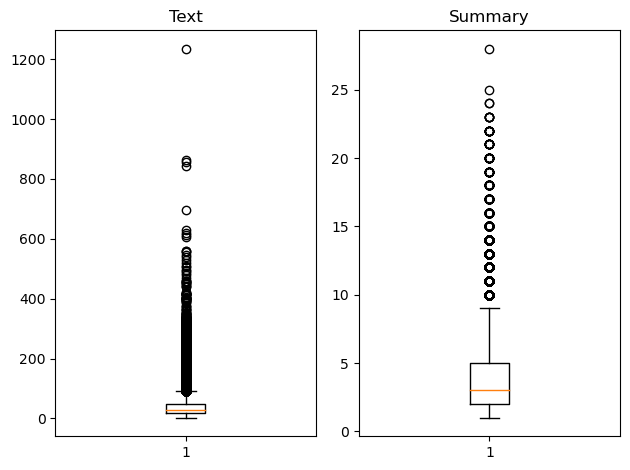

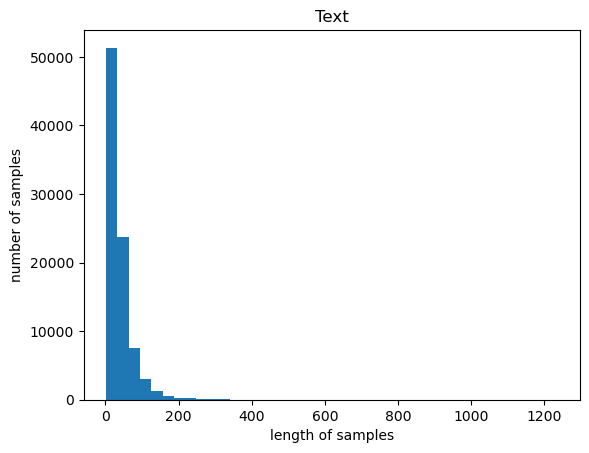

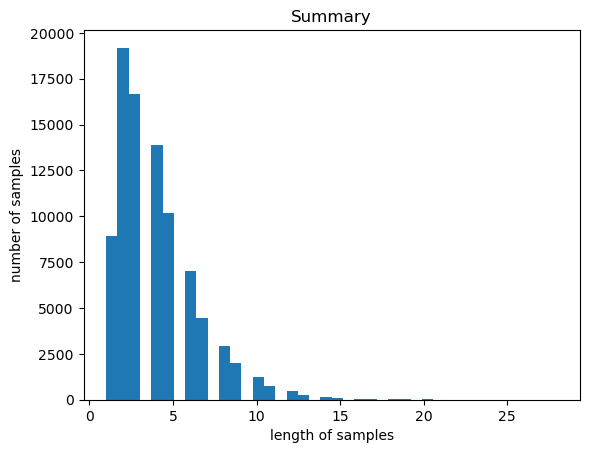

In [22]:
# 길이 분포 시각화 
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]


print('Text min : {}'.format(np.min(text_len)))
print('Text max : {}'.format(np.max(text_len)))
print('Text mean : {}'.format(np.mean(text_len)))
print('Summary min : {}'.format(np.min(summary_len)))
print('Summary max : {}'.format(np.max(summary_len)))
print('Summary mean : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.show()

In [23]:
text_max_len = 50
summary_max_len = 8

In [24]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [25]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859


In [26]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [27]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]       # Text의 길이가 50이하인 행 추출
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)] # Summary의 길이가 8이하인 행 추출 
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


In [28]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [29]:
data['Summary'] = data['Summary'].apply(lambda x : 'sostoken '+ x + ' eostoken')
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,sostoken good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised eostoken
2,confection around centuries light pillowy citr...,sostoken delight says it all eostoken
3,looking secret ingredient robitussin believe f...,sostoken cough medicine eostoken
4,great taffy great price wide assortment yummy ...,sostoken great taffy eostoken


In [30]:
Text_data = list(data['Text'])
Summary_data = list(data['Summary'])

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Text_data, Summary_data, test_size=0.2, random_state=0, shuffle=True)

print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))

X_train : 52654
y_train : 52654
X_test : 13164
y_test : 13164


In [32]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_train)

In [33]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0                              # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                            # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                             # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 
for key, value in src_tokenizer.word_counts.items():  # word_counts :단어의 빈도
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('--X_train--')
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

--X_train--
단어 집합(vocabulary)의 크기 : 31940
등장 빈도가 6번 이하인 희귀 단어의 수: 23707
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8233
단어 집합에서 희귀 단어의 비율: 74.22354414527238
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3949897589412323


In [34]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(X_train)


X_train = src_tokenizer.texts_to_sequences(X_train) 
X_test = src_tokenizer.texts_to_sequences(X_test)

In [35]:
print(X_train[:5])

[[4256, 611, 816, 4477, 528, 1540, 32, 45, 4, 79, 2281, 234, 19, 1157, 2923, 948, 1122, 996, 2, 153, 10, 43], [204, 15, 154, 51, 259, 60, 73, 24, 49, 17, 886, 259, 2, 29, 209, 14, 504, 2081, 420, 13, 86, 64, 22, 2464, 134, 14, 504, 86], [112, 1570, 2, 1771, 185, 39, 505, 112, 283], [296, 105, 496, 834, 69, 103, 334, 5082, 2294, 765, 7, 908, 585, 1489, 351, 5265, 100, 75, 1908, 137, 141, 585, 864, 5083, 89, 830, 564, 1772, 305, 254, 1541, 97, 247, 2, 1600, 2100, 92, 2645], [54, 1247, 806, 5, 497, 479, 46, 236, 1218, 381, 5, 3879, 3880, 172, 479, 46, 1247]]


In [36]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(y_train)

In [37]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)   # 단어의 수
rare_cnt = 0                                # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                              # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                               # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print('--y_train--')
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

--y_train--
단어 집합(vocabulary)의 크기 : 10498
등장 빈도가 5번 이하인 희귀 단어의 수: 8126
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2372
단어 집합에서 희귀 단어의 비율: 77.40522004191274
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.833194065065198


In [38]:
tar_vocab = 1000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
y_train = tar_tokenizer.texts_to_sequences(y_train) 
y_test = tar_tokenizer.texts_to_sequences(y_test) 

In [39]:
print(y_train[:5])
type(y_train)

[[1, 805, 2], [1, 7, 298, 138, 86, 2], [1, 25, 745, 2], [1, 488, 39, 22, 30, 12, 2], [1, 15, 16, 238, 84, 35, 12, 2]]


list

In [40]:
drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(y_test) if len(sentence) == 2]

In [41]:
print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))

X_train : 52654
y_train : 52654
X_test : 13164
y_test : 13164


In [42]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))
X_test.shape

X_train : 50512
y_train : 50512
X_test : 12609
y_test : 12609


C:\Users\User\anaconda3\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


(12609,)

### 토큰화와 패딩

In [43]:
X_train = pad_sequences(X_train, maxlen = text_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen = text_max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = summary_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen = summary_max_len, padding='post')

###  Seq2eq 와 Attention 사용 모델 구현

In [44]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
embedding_dim = 64
hidden_size = 128

# 인코더
encoder_inputs = Input(shape=(text_max_len,))  # text_max_len :50

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.0)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.0)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.0)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [46]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.0)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [47]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 64)       512000      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 128),    98816       ['embedding[0][0]']              
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [48]:
# 깃허브에 공개된 attention.py 사용하기
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [49]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 64)       512000      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 128),    98816       ['embedding[0][0]']              
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                            

In [50]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [51]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

# 약 9분 소요(GPU)
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:] \
                  ,epochs=50, callbacks=[es], batch_size = 256, validation_data=([X_test, y_test[:,:-1]], \
                  y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
198/198 [==============================] - 13s 42ms/step - loss: 2.8352 - val_loss: 2.5350
Epoch 2/50
198/198 [==============================] - 8s 39ms/step - loss: 2.4977 - val_loss: 2.4364
Epoch 3/50
198/198 [==============================] - 7s 38ms/step - loss: 2.3918 - val_loss: 2.3473
Epoch 4/50
198/198 [==============================] - 7s 37ms/step - loss: 2.3003 - val_loss: 2.2656
Epoch 5/50
198/198 [==============================] - 8s 39ms/step - loss: 2.2279 - val_loss: 2.2139
Epoch 6/50
198/198 [==============================] - 8s 39ms/step - loss: 2.1641 - val_loss: 2.1592
Epoch 7/50
198/198 [==============================] - 7s 38ms/step - loss: 2.1099 - val_loss: 2.1083
Epoch 8/50
198/198 [==============================] - 8s 40ms/step - loss: 2.0633 - val_loss: 2.0821
Epoch 9/50
198/198 [==============================] - 7s 38ms/step - loss: 2.0239 - val_loss: 2.0485
Epoch 10/50
198/198 [==============================] - 8s 39ms/step - loss: 1.9912 - val_l

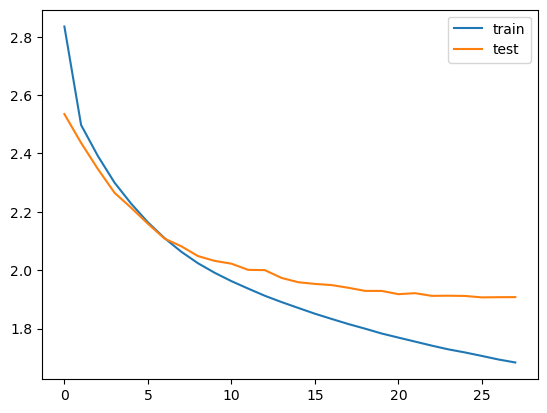

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

###  Test

In [53]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [54]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 64)            512000    
                                                                 
 lstm (LSTM)                 [(None, 50, 128),         98816     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 lstm_1 (LSTM)               [(None, 50, 128),         131584    
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
 lstm_2 (LSTM)               [(None, 50, 128),         1315

In [55]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [56]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     64000       ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                            

In [57]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [58]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [59]:
for i in range(500, 1000):
    print("원문 : ",seq2text(X_test[i]))
    print("실제 요약문 :",seq2summary(y_test[i]))
    print("예측 요약문 :",decode_sequence(X_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  dirty martini olive husband loves martini like people jars olives juice read company online actually cheaper order amazon husband fussy martini drinker loves amazing save buying lots jars olives never get used give try disappointed 
실제 요약문 : if you like 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great product


원문 :  impressed tuna ok companies efforts ended giving cans away used meal usually like tuna oil thought flavor lacking think tuna canned juices much better wild planet caught wild tuna ounce cans 
실제 요약문 : did not like too much 
1/1 [==============================] - 0s 12ms/step
예측 요약문 :  not as advertised


원문 :  coffee excellent delivered makes count lasts long enough two us month definitely keep coming 
실제 요약문 : good coffee 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great coffee


원문 :  buying coffee least years love smooth taste hint hazelnut friends enjoy coming good cup coffee 
실제 요약문 : great coffee 
1/1 [====================

1/1 [==============================] - 0s 16ms/step
예측 요약문 :  not as good as twinings


원문 :  syrup excellent quality great shame need two well great syrup non less 
실제 요약문 : the son 
1/1 [==============================] - 0s 13ms/step
예측 요약문 :  great product


원문 :  dr zevia may favorite zevia flavors think tastes like diet dr pepper stevia aftertaste minimal zevia flavors would highly recommend dr zevia 
실제 요약문 : delicious 
1/1 [==============================] - 0s 13ms/step
예측 요약문 :  refreshing


원문 :  great product shipping time great one bottles leaked happens kind container 
실제 요약문 : agave nectar 
1/1 [==============================] - 0s 13ms/step
예측 요약문 :  great product


원문 :  coffee taste like pleased purchase know costs met coffee expensive time doorstep unfortunately cannot always buy things would like buy due mentioned regular basis 
실제 요약문 : coffee lover 
1/1 [==============================] - 0s 13ms/step
예측 요약문 :  great coffee


원문 :  tea strong weird taste like fragran

1/1 [==============================] - 0s 16ms/step
예측 요약문 :  great product


원문 :  great deal great coffee drink every morning great flavor great price 
실제 요약문 : great coffee 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great coffee


원문 :  happy found wonderful decaf tea guests tea nice full flavored smooth finish usually use cup twice setting tea remains true delicious price best found anywhere 
실제 요약문 : mm good tea 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  great tea


원문 :  product used affordable price increase fewer boxes definitely worth 
실제 요약문 : price 
1/1 [==============================] - 0s 18ms/step
예측 요약문 :  too expensive


원문 :  got bbq popchips amazon promotion price came taste good wish less salty would certainly purchase came less salty version 
실제 요약문 : tasty but wish it was less salty 
1/1 [==============================] - 0s 19ms/step
예측 요약문 :  not the best


원문 :  great fresh finishing salt personally prefer murray river pin

1/1 [==============================] - 0s 30ms/step
예측 요약문 :  my dogs love it


원문 :  far favorite high antioxidant decaf tea flavor subtle perfect steep forever tea become bitter delicious since getting tea even considered trying another flavor decaf 
실제 요약문 : perfect tea for decaf lovers 
1/1 [==============================] - 0s 18ms/step
예측 요약문 :  best tea ever


원문 :  husband son love honey buying stores rather expensive wonderful velvet mouth great peanut butter clover honey also apply face inexpensive fan shaped craft honey anti bacteria properties using face wonderful smooth skin may even help acne amazon prime unbeatable price 
실제 요약문 : honey for my 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great for


원문 :  false labeling almonds like would find almond hershey bar tiny chips like sand almost cannot even taste want almonds waste money 
실제 요약문 : false dont waste your money 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  not bad


원문 :  love s

1/1 [==============================] - 0s 15ms/step
예측 요약문 :  love this coffee


원문 :  love tea vanilla flavors favorite type tea one favorite vanilla caramel flavors blend really well 
실제 요약문 : great tasting dessert tea 
1/1 [==============================] - 0s 18ms/step
예측 요약문 :  great tea


원문 :  used good mild kids liked changed slightly tart good source dried fruit hope go back old recipe 
실제 요약문 : they used to be good 
1/1 [==============================] - 0s 16ms/step
예측 요약문 :  good but not great


원문 :  reading reviews agree calling bars dry maybe got bad batch though overly moist find dry good cup coffee different taste weird one cocoa main thing notice walnuts raisins come well makers bar seemed found right combination ingrediants make one delicious snack bar 
실제 요약문 : different and delicious 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  not bad


원문 :  great chowder salty big chunks potato clam husband split lunch satisfying pop tops nice worry opener hand

1/1 [==============================] - 0s 16ms/step
예측 요약문 :  great tea


원문 :  recommend tea friends clients colds highly recommend anyone reading 
실제 요약문 : the best tea for your 
1/1 [==============================] - 0s 16ms/step
예측 요약문 :  great tea


원문 :  excited find seasoning amazon considering sold currently live lived new mexico used seasoning everything kept right next salt pepper versatile excited use 
실제 요약문 : best seasoning ever 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  not what expected


원문 :  huge hit staff receive job well done everything arrived good shape despite summer heat cannot go wrong gift 
실제 요약문 : wonderful 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great gift


원문 :  nantucket blend perfect smooth medium blend right amount caffeine wake morning almost creamy almost tastes like slight vanilla flavor take word slightly vanilla definitely coffee connoisseur guess think creamy yummy tasting 
실제 요약문 : yummy smooth coffee 


1/1 [==============================] - 0s 24ms/step
예측 요약문 :  great product


원문 :  excellent product ten pound chihuahua suffers skin allergies tried food products grain chicken free loves product recommend highly ordered amazon could satisfied 
실제 요약문 : excellent dog food 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great food


원문 :  long lists chemical additives either nice find something quick easy feel guilty giving kids time time problem paying little bit premium annie well worth oh anyone getting lumps take package directions face value mix cheese separately add pasta 
실제 요약문 : no more orange cheese 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great for


원문 :  really enjoyed mix tasty bread baking mix pamela also amazing pancakes 
실제 요약문 : tasty mix 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  best gluten free bread mix


원문 :  packages came tiny pits pieces one piece bigger thumb nail picture deceiving texture good overly 

1/1 [==============================] - 0s 16ms/step
예측 요약문 :  great alternative to regular


원문 :  shipped fast great product dog teeth giving poodle greenies years vet said teeth white healthy year old dogs years old 
실제 요약문 : greenies 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  great product


원문 :  leery product hooked really easy one pot clean kids loved happy added cut chicken vegetables broccoli snap peas red peppers along bread garden salad perfect dinner moist tasty normally use crock pot liked even better big crock clean quick easy alternative dinner idea kids love eat cheese sauce 
실제 요약문 : fast easy one dinner 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great for


원문 :  first tried glass straight strong aromatic coffee smell good dark color strong coffee flavor hint sweetness next heated cup microwave consistent results surprisingly good canned coffee 
실제 요약문 : tasty hot or cold 
1/1 [==============================] - 0s 16ms/step
예측 요약

1/1 [==============================] - 0s 26ms/step
예측 요약문 :  great product


원문 :  adorable authentic looking ladies party thought adorable 
실제 요약문 : take on these 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great product


원문 :  switched holistic dog food products yr old mixed breed started itching scratching shedding losing weight cannot say enough good things holistic select products dog never healthier happier scratching shedding highly recommend products 
실제 요약문 : excellent dog biscuits 
1/1 [==============================] - 0s 16ms/step
예측 요약문 :  my dog loves it


원문 :  could make better batter scratch would stuff pretty economical though tastes great light right amount crunch sweetness bother shopping better scratch batter better let know 
실제 요약문 : just the best 
1/1 [==============================] - 0s 35ms/step
예측 요약문 :  good but not great


원문 :  purchased outstanding reviews needed cute yummy animal cookies nieces baby shower making banana pudding dish 

1/1 [==============================] - 0s 18ms/step
예측 요약문 :  great candy


원문 :  since republic tea discontinued cherry vanilla tea looking replacement flavor tea different better smell rich like toasted vanilla cherry almost coffee smell quite like coffee tea incredible glad found best price 
실제 요약문 : should be tasty cherry 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  not bad


원문 :  bit surprised writing high recommendation microwave popcorn much expectation popcorn flavorful overly greasy buttery salty kernels pop bright fluffy white also noticed design material bag quite different probably played part preventing burning experienced many brands microwave popcorn also get large number unpopped kernels partially popped kernels favorite crunchy 
실제 요약문 : great tasting microwave popcorn finally 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  popcorn


원문 :  experimenting flavored coffees looked like fun feel little bit artificial aftertaste tolerable th

1/1 [==============================] - 0s 16ms/step
예측 요약문 :  great coffee


원문 :  two kids tried various formula brands enfamil similac parent choice kirkland exception similac one kids seem like take brand mostly use kirkland buy bright available sale kids problem sure better worse brands since manufacturers supposed follow fda standards see reason overpriced brand 
실제 요약문 : best quality for the price 
1/1 [==============================] - 0s 18ms/step
예측 요약문 :  great for baby


원문 :  excellent product tastes exactly way want huckleberry fix thing get 
실제 요약문 : delicious 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great product


원문 :  second shipment community coffee use keurig coffeemaker cups fill ins cups hubby quite picky coffee mentioned several times much like brand 
실제 요약문 : coffee 
1/1 [==============================] - 0s 21ms/step
예측 요약문 :  great coffee


원문 :  galil roasted chestnuts ok absolutely need substitute fresh chestnuts found slightly mushy cr

1/1 [==============================] - 0s 17ms/step
예측 요약문 :  great product


원문 :  husband loves energy drinks person buy really fan one since relatively similar ingredients concerned taste thought one great buying 
실제 요약문 : it is all right 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great product


원문 :  bought coffeemaker tried several different brands types coffee one become stable count great cup coffee strong mild way like drink coffee probably taste downside 
실제 요약문 : great coffee 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great coffee


원문 :  care product thought tea sisters use drink school found tea use drink actually came root particular type tree 
실제 요약문 : tea 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  good tea


원문 :  hard crunchy salty hint burnt taste gritty chewing need washed water hoping something like cheetos probably possible pure cheese prefer chips made microwaving slices cheddar positive low carb snack ne

1/1 [==============================] - 0s 23ms/step
예측 요약문 :  not as good as expected


원문 :  dogs like probably main point hard time finding non dry dog food treats put inside toy still dogs seemed jolly time complain lack treat variety 
실제 요약문 : treat toy 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  my dog loved it


원문 :  bought give homeless people street seem really appreciate nice thing melt goo put pocket 
실제 요약문 : perfect little gift that does not 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  my dog loves these


원문 :  love brand would buy anything different spices perfect best vanilla soymilk makes day 
실제 요약문 : cannot live without it 
1/1 [==============================] - 0s 16ms/step
예측 요약문 :  best ever


원문 :  simply put tea incredible would say like tea never really crave tea except one cup hand sitting leather find relaxation flavor rich distinctive couple cups time nearly taste thinking confusing fan bitter flavors brew dark drink stra

1/1 [==============================] - 0s 16ms/step
예측 요약문 :  do not buy


원문 :  bought walmart less dollars box box amazon need add another dollars order get free shipping would buy could better added chicken egg like reviewers mentioned box say gluten free maybe versions 
실제 요약문 : okay in 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great taste but not for me


원문 :  use stuff days workouts since natural electrolyte replacement tastes good keeps energy 
실제 요약문 : yum 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great energy


원문 :  crisp butter snap loads butter flavour top picks almond crisp waffles cookie time 
실제 요약문 : for all butter lovers 
1/1 [==============================] - 0s 16ms/step
예측 요약문 :  love these


원문 :  dogs love taste love company especially convenient delivered rather home 
실제 요약문 : quality organic dog food 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great product


원문 :  bit pricy well worth avoid garbage f

1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great snack


원문 :  daughter excited trying flavor love orange juice product impress us enough order liked flavors son also tried care orange tangerine flavors masked fruit juices makes taste odd like fact added vitamin healthy alternative sodas flavor one needs 
실제 요약문 : not as tasty as it could be 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  not bad


원문 :  container medium size like size convient purchase item could find small container local grocery store love cook beef flavored bouillon great purchase 
실제 요약문 : beef flavored 
1/1 [==============================] - 0s 21ms/step
예측 요약문 :  love this stuff


원문 :  gag birthday gift time company finally got around telling stock late happy experience 
실제 요약문 : product was 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great gift


원문 :  like marshmallow squishy texture marshmallow bit firm side doesnt contribute much overall flavor saying ove

1/1 [==============================] - 0s 17ms/step
예측 요약문 :  great gift


원문 :  sure much say gum favorite gum decided buy bulk big container looks pretty prone open gets knock table desk one star case likely keep stocks refreshed another order road 
실제 요약문 : gum with nice bite 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  gum


원문 :  purchased sauce local grocery store afternoon opened gave quick taste absolutely flavor realized know company would put bland product spices taste readily available bad product buy something else 
실제 요약문 : poor at best 
1/1 [==============================] - 0s 19ms/step
예측 요약문 :  not bad


원문 :  bought dad years would complain tea since finally many nights drinking tea annoyed bought tea would shut 
실제 요약문 : lovely 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great tea


원문 :  yuck worst chocolate ever save money brand find another even taste taste like chocolate threw rest away 
실제 요약문 : horrible chocolate 
1/1 [=====

1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great product


원문 :  great tasting tea mellow flavor without aftertaste compared rooibos teas vanilla takes edge aftertaste little vanilla may improve taste little comes personal preference kudos stash providing high quality organic tea 
실제 요약문 : vanilla 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  not bad


원문 :  receive order month already probably made sprout times result excellent time little one table spoon seeds get one large mason jar full alfalfa sprout week definitely continue order seeds sprouting 
실제 요약문 : great seeds 
1/1 [==============================] - 0s 20ms/step
예측 요약문 :  seeds


원문 :  love taste crispiness cereal black currants walnuts great flavor mouth feel 
실제 요약문 : my favorite cereal 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great taste


원문 :  remember product well extremely disappointed taste licorice whatsoever taste mint soft nearly melted mouth instead nice

1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great for


원문 :  nice smooth flavor adding little heavy cream condensed milk make tea drinking experience even nicer 
실제 요약문 : care for cup of tea 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great tea


원문 :  used order mail nyc buy person carry home easy order online best honey world guess greek bees sweeter us 
실제 요약문 : honey 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  delicious


원문 :  good thirst quencher milky thicker expected would call pineapple flavor one get idea pineapple 
실제 요약문 : flavor 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  good taste


원문 :  switched food months ago quality ingredients cats new healthy bodies fat cat almost completely lost belly little boy pretty sure food unless maybe started working work 
실제 요약문 : kitty in bag 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  my cats love this food


원문 :  used ultra cubes chicken bro

1/1 [==============================] - 0s 15ms/step
예측 요약문 :  too much


원문 :  feeding cat food past year loves gotten sick shows signs sick weeks ago got clean bill health vet know nothing food potentially harmful really like food fact animal products plus would recommend newman dry cat food 
실제 요약문 : great food worth the money 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  my cats love this food


원문 :  like hot cocoa much rich taste compared others tried bought grove square single serve hot cocoa cups milk cups keurig brewers cocoa 
실제 요약문 : hot cocoa for keurig 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great cocoa


원문 :  mashed vegetable curry one meals included kitchens india ready eat dinner variety pack ounce boxes like dish much others kitchens india fairly bland flavor making suited side dish little spicy packet say contains servings closer family also makes enjoyable snack well recommended cfh 
실제 요약문 : good heat and eat recommended 
1/1 

1/1 [==============================] - 0s 14ms/step
예측 요약문 :  love this stuff


원문 :  mexican varieties perfect exactly described trying first time couple years ago even look brands vendor delivers promised 
실제 요약문 : best vanilla have ever used 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  love this candy


원문 :  acid cream tartar thing cream tartar made acid weak salt derived acid half potassium home recipes call acid substitute tsp cream tartar tsp acid buying acid looking cream tartar seller label cream tartar acid 
실제 요약문 : acid and cream of 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  how


원문 :  puppy loves couple weeks developed spot chest sure chews discontinue find wrong really likes though also castor puppy food developed skin problem til gave rawhide 
실제 요약문 : my puppy may be 
1/1 [==============================] - 0s 16ms/step
예측 요약문 :  my dog loves it


원문 :  tried every single french roast cup one favorites starbucks barista prima two be

1/1 [==============================] - 0s 14ms/step
예측 요약문 :  love it


원문 :  obviously real wasabi still hot pale green taste good ingredients wasabi listed last obviously minimal best made sushi make wasabi wings works great goes great mexican whatever 
실제 요약문 : if you know what you to expect 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  delicious


원문 :  know people dislike banana nut bread also know people make really good banana nut bread one problem banana nut bread self control bar fix things taste enjoyment banana nut bread perfect portion packaged perfectly go snack trick warm microwave seconds simple snack wonderful healthy desert 
실제 요약문 : delicious and nutritious 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great snack


원문 :  bought vending machine local place business want go back place candy purple ones awesome 
실제 요약문 : awesome 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  love these


원문 :  got cat shelter feed cats c

1/1 [==============================] - 0s 14ms/step
예측 요약문 :  not the same as the


원문 :  excited get hot chocolate cups keurig even happier variety pack read reviews even negative ones went anyways tried milk chocolate weird taste gave benefit doubt tried another later night weird aftertaste asked husband try make sure taste buds commented hot plastic aftertaste even worth drinking bad cups go waste 
실제 요약문 : had much 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  not for me


원문 :  turned bit bread making animal bit white whole wheat italian types made loaf using cups high gluten flour cup rye flour still lot learn using product flavor excellent sure remember add seeds near end working dough really enhances flavor shipping delivery first class happy item update learn 
실제 요약문 : good stuff 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great product


원문 :  odd little tea berries produce tea wonderful flavor price wonderful compared price lipton tea groc

1/1 [==============================] - 0s 15ms/step
예측 요약문 :  not bad


원문 :  product exceeded expectations never thought could get great coffee refreshing light looking 
실제 요약문 : excellent 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great coffee


원문 :  one favorite teas either hot iced packet splenda 
실제 요약문 : the perfect herbal tea 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great tea


원문 :  trying another brand tried one ingredient soy flour add handful sometimes soup works well easily flavor whatever cooking adds nice texture 
실제 요약문 : simple ingredients works well 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great for cooking


원문 :  although love actual product delicious healthy arrived broken million barely bite size pieces would mind however even big enough dip anything messy eat ended throw half crackers away 
실제 요약문 : broken 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  broken


원문 :  love pineapple fl

1/1 [==============================] - 0s 19ms/step
예측 요약문 :  not what expected


원문 :  kids enjoyed granola nice fresh taste chocolate bonus daughter normally eat granola put homemade ice cream gobbled ate cereal milk enjoyed happy every back nature product purchased exception would buy 
실제 요약문 : fresh flavor 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great cereal


원문 :  first dessert italy class finished reading lion enjoyed dismay could find returned states came magic internet finally found brought back wonderful memories taste light sweet happy able order whenever want 
실제 요약문 : absolutely 
1/1 [==============================] - 0s 16ms/step
예측 요약문 :  love these


원문 :  one favorites tassimo medium flavor coffee would say coffee expert like automatically set tassimo make oz cup instead oz cup great flavor morning 
실제 요약문 : morning roast 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great coffee


원문 :  hit bitter like maybe carrots sweet peeled

1/1 [==============================] - 0s 15ms/step
예측 요약문 :  my dogs love this food


원문 :  buying mini bones amazon sold brand name could find brand anymore started buying brand since smell bones different dogs would eat dip milk first love glad small bones discontinued since easy chew 
실제 요약문 : my dogs love the mini bones 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  my dogs love these


원문 :  brewing tea chilled served iced tea good hot summer afternoon 
실제 요약문 : nice tangy tea 
1/1 [==============================] - 0s 16ms/step
예측 요약문 :  great tea


원문 :  pretty substantial cookie decent amount fiber conveniently packaged work school calories per cookie diet food opinion gourmet treat dry soft cookie pleasant chocolate almond flavor decent choice school lunch th go snack satisfy cookie lover wanting treat 
실제 요약문 : lunch snack 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  good snack


원문 :  ordered product themed baby shower went well tasted like

1/1 [==============================] - 0s 16ms/step
예측 요약문 :  great coffee


원문 :  love stuff tastes like real peanut butter fat calories using peanut butter jelly protein shakes etc 
실제 요약문 : amazing 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  delicious


원문 :  need lot words review honey tastes better healthier less expensive store bought honey usual amazon service great 
실제 요약문 : stuff 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  great taste


원문 :  great product takes flavor whatever cooked get mushy stays nice firm simple prepare one package enough person 
실제 요약문 : miracle noodle hair pasta 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great taste


원문 :  first harney sons paris tea resort oregon may rainy cold sick looked forward tea morning amazing aroma flavor incredibly soothing ordered online shortly getting home favorite tea ever ran sachets saved tin little secret occasionally open tin take whiff smells good 
실제 요약문 : te

1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great taste


원문 :  hi black tea everyday done past years habit mine ahmad tea one favorite brands highly recommend like black tea think going remain favorite next years 
실제 요약문 : my everyday cup of tea 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  great tea


원문 :  oh mess old version tastes nothing like used chewy sweet strange mouth feel anyone recommend bar tastes like previous recipe done lindt 
실제 요약문 : why 
1/1 [==============================] - 0s 15ms/step
예측 요약문 :  yuck


원문 :  dogs love peanut butter crackers last one finally came around eats seem little dry think go waste price good shipping time fine 
실제 요약문 : dog treats 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  my dogs love these


원문 :  go use white tea slight taste odor use anymore may like fine 
실제 요약문 : use 
1/1 [==============================] - 0s 14ms/step
예측 요약문 :  good tea


원문 :  bought safeway swiss chocolate alm

In [ ]:
decoder_model.summary()